# Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from mpl_toolkits import mplot3d
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# Datasets

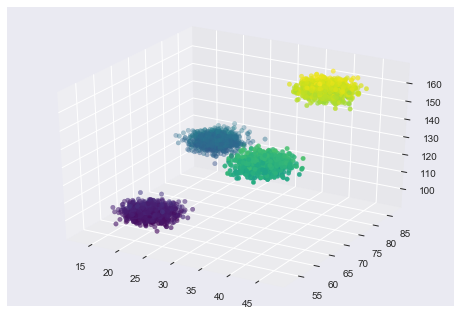

In [2]:
from data.synthetic import get_tf_normal_dataset

dataset = get_tf_normal_dataset(1000, xy_features=(2,1), plot=True)

# Gaussian Mixture Density Network

The Gaussian mixture model (GMM) is a probabilistic model for representing normally distributed subpopulations within an overall population. A Gaussian mixture model is parameterized by the mixture component weights, means and covariances. The Expectation-Maximisation algorithm assigns data to each cluster with a probability. The GMM gives a probability model of x, a “generative” model.

For each input x, predict a probability density function (pdf) of $P(Y=y|X=x)$ that is a probability weighted sum of smaller Gaussian probability distributions.


$$P(y|x) = \sum_{k}^{K} \Pi_{k}(x) \mathcal{N}(y|\mu_{k}(x), \sigma_{k}^{2}(x))$$

Each parameter $\Pi_{k}(x), \mu_{k}(x), \sigma_{k}(x)$ is approximated by a neural network as a function of input $x$:

$$Z = W_{o} \tanh( W_{h} X + b_{h}) + b_{o}$$

where 

$$\Pi_{k} = \frac{\exp(Z_{k})}{\sum exp(Z)}, \sigma = \exp(Z), \mu = Z$$

Reference:
* https://cedar.buffalo.edu/~srihari/CSE574/Chap5/Chap5.6-MixDensityNetworks.pdf

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from mpl_toolkits import mplot3d
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions


class GMM:
    """Gaussian Mixture Density Network."""
    def __init__(self, x_features=2, y_features=1, n_components=4, n_hidden=50, verbose=False):
        self.x_features = x_features  # no. of input features
        self.y_features = y_features  # no. of output features
        self.n_components = n_components  # no. of components
        self.n_hidden = n_hidden  # no. of hidden units 
        self.verbose = verbose
        self.build()
    
    def build(self):
        """Compile TF model."""
        input = tf.keras.Input(shape=(self.x_features,))
        layer = tf.keras.layers.Dense(self.n_hidden, activation='tanh')(input)

        mu = tf.keras.layers.Dense(self.n_components * self.y_features)(layer)
        sigma = tf.keras.layers.Dense(self.n_components * self.y_features, activation='exponential')(layer)
        pi = tf.keras.layers.Dense(self.n_components, activation='softmax')(layer)

        self.model = tf.keras.models.Model(input, [pi, mu, sigma])
        self.optimizer = tf.keras.optimizers.Adam()
        
        if self.verbose:
            print(self.model.summary())
        
    def tfdGMM(self, pi, mu, sigma):
        """Tensorflow Probability Distributions GMM."""
        mu = tf.reshape(mu, (self.n_components, self.y_features))
        sigma = tf.reshape(sigma, (self.n_components, self.y_features))
        return tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=pi),
            components_distribution=tfd.MultivariateNormalDiag(loc=mu,
                                                               scale_diag=sigma))

    def loss(self, X, y, training=False):
        pi, mu, sigma = self.model(X, training=training)
        samples = pi.shape[0]
        losses = 0
        for i in range(samples):
            gmm = self.tfdGMM(pi[i], mu[i], sigma[i])
            loss = gmm.log_prob(y[i])
            loss = tf.negative(loss)
            losses += loss
        return losses / samples
    
    @tf.function
    def train_step(self, X, y):
        """TF train function."""
        with tf.GradientTape() as t:
            loss = self.loss(X, y, training=True)
        gradients = t.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss
    
    def fit(self, dataset, epochs=1000, plot=False):
        """Fit with TF dataset."""        
        # Tensorboard
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        train_summary_writer = tf.summary.create_file_writer('logs/gmm/' + current_time + '/train')
        
        for i in range(epochs):
            for train_x, train_y in dataset:
                loss = self.train_step(train_x, train_y)
            with train_summary_writer.as_default():
                tf.summary.scalar('NLL', loss, step=epoch)
        return loss
            
    def prob(self, X, y):
        """Compute probability of y given X."""
        pi, mu, sigma = self.model(X) 
        samples = pi.shape[0]
        y_prob = []
        for i in range(samples):
            y_prob.append(self.tfdGMM(pi[i], mu[i], sigma[i]).prob(y[i]).numpy())
        return np.array(y_prob)
        
    def sample(self, X):
        """Sample y given X."""
        pi, mu, sigma = self.model(X) 
        samples = pi.shape[0]
        y_pred = []
        for i in range(samples):
            y_pred.append(self.tfdGMM(pi[i], mu[i], sigma[i]).sample().numpy())
        return np.array(y_pred)
    
    def sample_fixed(self, X_fixed, count=20):
        X = np.stack([np.full(count, fill_value=x) for x in X_fixed], axis=1)
        return self.sample(X)

# Model Training

In [4]:
from model.gmm import GMM
# Build GMM
gmm = GMM(x_features=2,
          y_features=1,
          n_components=4,
          n_hidden=10, verbose=True)
gmm.fit(dataset, epochs=300, plot=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 4)            44          dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 4)            44          dense[0][0]                      
______________________________________________________________________________________________

<tf.Tensor: shape=(), dtype=float32, numpy=3.0436096>

In [13]:
%load_ext tensorboard
%tensorboard --logdir logs/gmm --host localhost

Reusing TensorBoard on port 6006 (pid 9288), started 0:01:01 ago. (Use '!kill 9288' to kill it.)

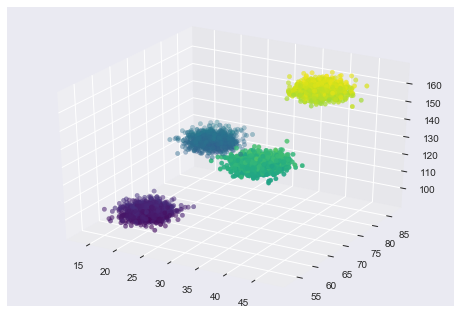

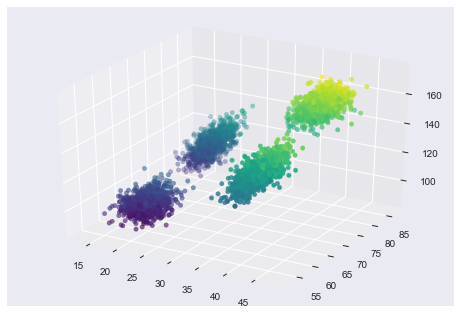

In [5]:
y_hat = gmm.sample(X)
plot_data(X, y)
plot_data(X, y_hat)

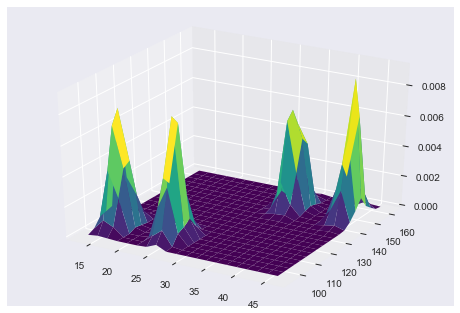

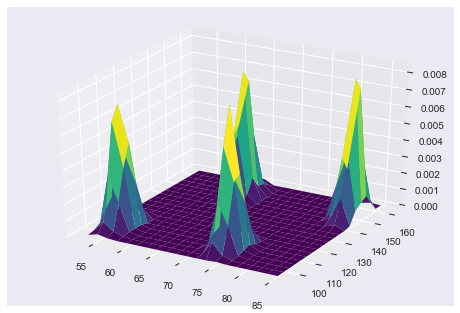

In [6]:
from visualisation.visualisation import Visualisation

viz = Visualisation(gmm, X, y)

# Plot the density function based on X1 and X2
viz.plot_prob(X[:,0], y[:,0], bins=20)
viz.plot_prob(X[:,1], y[:,0], bins=20)

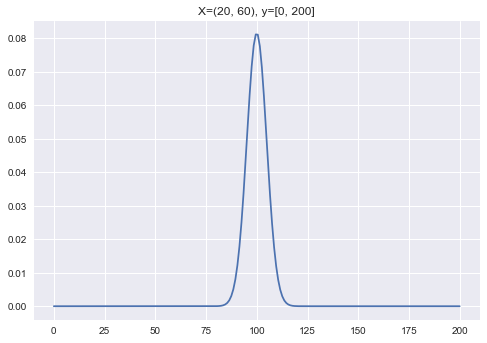

In [7]:
# Plot probability density function given X_fixed across y_range.
viz.plot_prob_fixed(X_fixed=(20,60), y_range=[0,200], count=200)

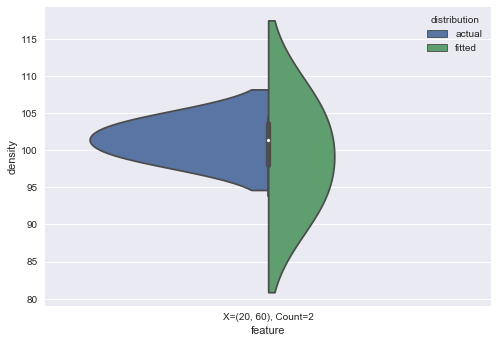

In [8]:
# Given X, plot a violin of y based on X within a tolerance, to compare the distribution between fitted and actual.
# X_tol represents the tolerance to which X data is binned to get the corresponding y.
# X_fixed represents the X fed into the model to sample y.
viz.plot_prob_violin(X_fixed=(20,60), X_tol=(0.1,0.1))

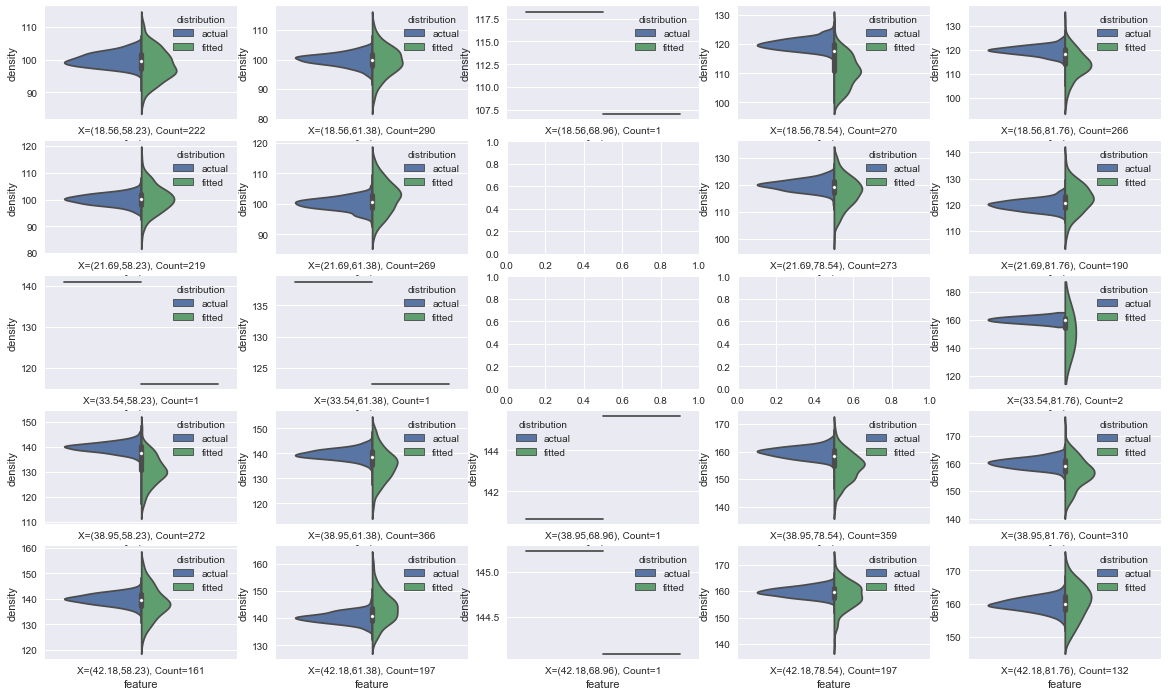

In [9]:
# Given X and y, plot a violin of y based on binned X, to compare between fitted and actual.
# For the actual distribution, bin X and plot violin plots for the density of y.
# For the fitted distribution, input the mean of binned X and plot violin plots for the density of sampled y.
viz.plot_binned_violin(bins=5)

# Performance

In [13]:
def compute_probs(data, n=10): 
    h, e = np.histogram(data, n)
    p = h/data.shape[0]
    return e, p

In [14]:
a = np.linspace(0,10,10)
compute_probs(a, n=10)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]))

In [15]:
from scipy.special import softmax

pdf, bins = np.histogram(a, bins=10, density=True)
pdf, bins

(array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))